##Submitted by Sanjay Mamidi 5/4/2019

In [190]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [193]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [194]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [195]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [196]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [197]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [198]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [199]:
inspector = inspect(engine)
columns = inspector.get_columns("Measurement")
for column in columns:
    print(column['name'], column['type'])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [200]:
columns = inspector.get_columns("station") 
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


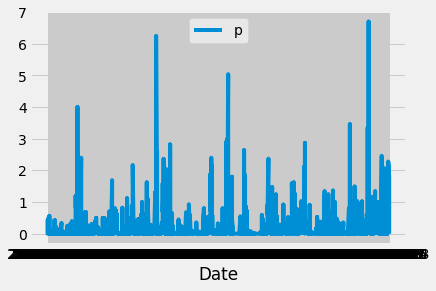

In [201]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
maxdate= session.query(Measurement.date).order_by(Measurement.date.desc()).first()
maxdate = (maxdate[0].split("-"))
lastyeardate = dt.date(int(maxdate[0]) - 1, int(maxdate[1]),int(maxdate[2]))        

# Perform a query to retrieve the data and precipitation scores
df = session.query(Measurement.prcp,Measurement.date).\
    filter(Measurement.prcp >= 0 ).\
    filter(Measurement.date >= lastyeardate).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(df)
df = df.set_index("date")
df = df.reset_index()

# Sort the dataframe by date
df = df.sort_values(by=['date'],ascending=False)

# Use Pandas Plotting with Matplotlib to plot the data
#fig, ax = plt.subplots()
plt.plot(df['date'], df['prcp'])
# plt.figure(figsize=[8,10])
plt.xlabel("Date")
plt.legend(labels = "precipitation",loc="upper center")
plt.grid =True
plt.show()


In [202]:
# Use Pandas to calcualte the summary statistics for the precipitation data
## Not clear if this is for all dates or just vacation dates. Used all dates.
df = session.query(Measurement.prcp,Measurement.date).all()
df = pd.DataFrame(df)
df.reset_index()
df.describe()


,prcp
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


In [203]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).\
group_by(Measurement.station).all()

[('USC00511918'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00516128'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519281'),
 ('USC00519397'),
 ('USC00519523')]

In [204]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
order_by(func.count(Measurement.station).desc()).\
group_by(Measurement.station).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [205]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.max(Measurement.tobs),func.min(Measurement.tobs),\
              func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()

[(85.0, 54.0, 71.66378066378067)]

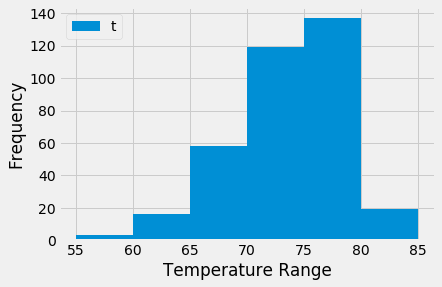

In [206]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station 
# and plot the results as a histogram
df = session.query(Measurement.tobs,Measurement.date).\
    filter(Measurement.prcp >= 0 ).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= lastyeardate).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(df)
df = df.set_index("date")
df = df.reset_index()


# # Use Pandas Plotting with Matplotlib to plot the data
# #fig, ax = plt.subplots()

bins =[55,60,65,70,75,80,85] 
plt.hist(df['tobs'],bins)
# # plt.figure(figsize=[8,10])
plt.xlabel("Temperature Range")
plt.ylabel("Frequency")
plt.legend(labels = "tobs",loc="upper left")
plt.show()

In [207]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2016-11-20', '2016-11-30'))

[(67.0, 74.32352941176471, 80.0)]


In [208]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tempdata=[]
temp = calc_temps('2016-11-20', '2016-11-30')
tmin= temp[0][0]
tavg = int(temp[0][1])
tmax = temp[0][2]
tempdata.append(tmin)
tempdata.append(tmax)
tempdata.append(tavg)
tempdata.append(tmax-tmin)
tempdata

[67.0, 80.0, 74, 13.0]

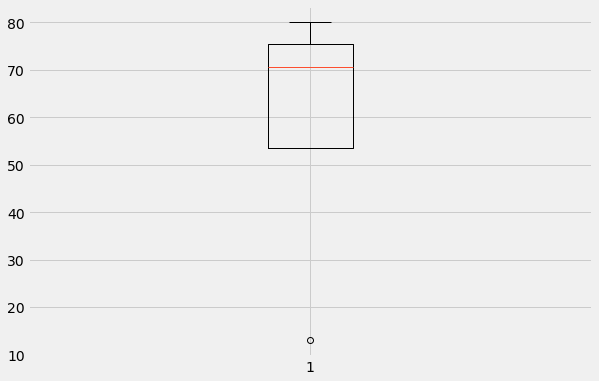

In [209]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(tempdata)
plt.show()

In [210]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.execute("select a.station , b.name,round(sum(a.prcp),2),b.latitude,\
                b.longitude, b.elevation from Measurement a,Station b \
                where a.station = b.station and a.date >= '2016-11-20 and a.date <= 2016-11-30'\
                group by a.station \
                order by a.prcp desc").fetchall()


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 94.91, 21.3331, -157.8025, 152.4),
 ('USC00519281', 'WAIHEE 837.5, HI US', 53.33, 21.45167, -157.84888999999998, 32.9),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 30.42, 21.33556, -157.71139, 19.5),
 ('USC00513117', 'KANEOHE 838.1, HI US', 39.94, 21.4234, -157.8015, 14.6),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 12.99, 21.2716, -157.8168, 3.0),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 25.24, 21.5213, -157.8374, 7.0),
 ('USC00517948', 'PEARL CITY, HI US', 3.74, 21.3934, -157.9751, 11.9)]

## Optional Challenge Assignment

In [211]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [222]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
StartDate = '2017-11-20'
EndDate = '2017-11-30'
StartDate = StartDate.split("-")
StartDate = dt.date(int(StartDate[0]), int(StartDate[1]),int(StartDate[2]))  
EndDate = EndDate.split("-")
EndDate = dt.date(int(EndDate[0]), int(EndDate[1]),int(EndDate[2]))  
normals=[]
setoftemps =()
while StartDate <= EndDate :
    results = daily_normals(str(StartDate.month) + "-" + str(StartDate.day))
    setoftemps = (str(results[0][0]),str(results[0][1]),str(results[0][2]),StartDate)
    normals.append(setoftemps)
    StartDate +=dt.timedelta(days=1)
normals


[('67.0', '73.03921568627452', '80.0', datetime.date(2017, 11, 20)),
 ('66.0', '73.34', '81.0', datetime.date(2017, 11, 21)),
 ('65.0', '71.98', '80.0', datetime.date(2017, 11, 22)),
 ('64.0', '72.2', '80.0', datetime.date(2017, 11, 23)),
 ('66.0', '72.56521739130434', '77.0', datetime.date(2017, 11, 24)),
 ('63.0', '72.43181818181819', '78.0', datetime.date(2017, 11, 25)),
 ('67.0', '73.51063829787235', '78.0', datetime.date(2017, 11, 26)),
 ('63.0', '73.03921568627452', '78.0', datetime.date(2017, 11, 27)),
 ('62.0', '72.75510204081633', '80.0', datetime.date(2017, 11, 28)),
 ('62.0', '71.01960784313725', '79.0', datetime.date(2017, 11, 29)),
 ('61.0', '71.8076923076923', '79.0', datetime.date(2017, 11, 30))]

In [232]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals,columns=['Min', 'Avg', 'Max','VacayDate'])
df['Vacaydate'] = pd.to_datetime(df['VacayDate'])
df = df.set_index('Vacaydate')
df["Min"]= pd.to_numeric(df["Min"])
df["Max"] = pd.to_numeric(df["Max"])
df["Avg"] = pd.to_numeric(df["Avg"])
df

,Min,Avg,Max,VacayDate
Vacaydate,,,,
2017-11-20,67.0,73.039216,80.0,2017-11-20
2017-11-21,66.0,73.340000,81.0,2017-11-21
2017-11-22,65.0,71.980000,80.0,2017-11-22
2017-11-23,64.0,72.200000,80.0,2017-11-23
2017-11-24,66.0,72.565217,77.0,2017-11-24
2017-11-25,63.0,72.431818,78.0,2017-11-25
2017-11-26,67.0,73.510638,78.0,2017-11-26
2017-11-27,63.0,73.039216,78.0,2017-11-27
2017-11-28,62.0,72.755102,80.0,2017-11-28


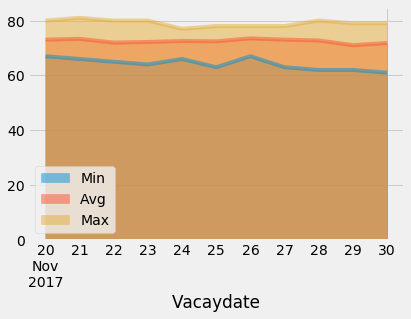

In [233]:
# Plot the daily normals as an area plot with `stacked=False`
# Your x and y axis
df.plot.area(stacked=False)
plt.show()

